---
>「私になるのは簡単よ。  
> 髪をハネさせて、大きなサングラスをかけて、 小さなノースリーブのドレスを着たら、  
> 誰だってオードリー・ヘプバーンだわ」  
> オードリー・ヘプバーン
---

**このノートブックはハイメモリでの実行が必要です**

# StyleGANの様々な応用と工夫

ここで、StyleGANで施されている様々な工夫について、その効果を確認する
- まずは実行してみよう
- 5分弱程度必要となるので注意すること

## 関連モジュールのインストール

In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.0 MB/s eta 0:00:00


stylegan2-ada-pytorchをダウンロードする

In [2]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128 (from 1)
Receiving objects: 100% (131/131), 1.13 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [3]:
%cd stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


## Mixing RegularizationとStyle Mixing

### Mixing Regularization

StyleGANは学習中にStyleに用いられる潜在変数を2つ混ぜるという正則化手法を利用
- 例えば、潜在変数$z_1$と$z_2$から得られる$w_1$と$w_2$のスタイルベクトルについて、$w_1$を4x4の画像生成に、$w_2$を8x8の画像生成に用いることができる
- 結果、2つの画像のStyleをうまく混ぜることができる
- 図のような合成が可能となる

図はSource AとSourceBの画像それぞれを生成する潜在変数をAとBを準備し、最初はAを使い、ある解像度からBを使った場合の結果を表す
- 切り替える解像度を低解像(4² ~ 8²)・中解像(16² ~ 32²)・高解像(64~1024²)の3通りとしている
- なお、低解像から入れたStyleの影響が大きくなる
- また、低解像からBの潜在変数を使うと顔の形や肌の色、性別年齢などがBに近く、高解像で使うと背景や髪の色などしか影響を与えない
- Mixing Regularizationは学習過程での話であり、学習済みモデルを用いたモーフィングとは異なることに注意する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/MixingRegularization.png" width=500>


### Style Mixing
- ffhqを用いた人物の顔画像の合成例を'figure03-style-mixing.png'で確認しよう
  - この例では、Synthesis networkの各層に入力されるスタイルのうち、解像度の低い層（4×4から8×8）、解像度が中程度の層（16×16から32×32）、解像度の高い層（64×64から1024×1024）を他の画像のベクトルに入れ替えることで2つの画像の特徴をミックスさせることができる
  - 最上行の元画像5種`[639,701,687,615,2268]`および最左列のスタイル画像`[888,829,1898,1733,1614,845]`について合成している
  - 解像度の低い層へ入力するスタイルをCoarse Style、中程度へはMiddle Style、高い場合はFine Styleと呼ぶ
    - `[range(0,4)]*3+[range(4,8)]*2+[range(8,18)]`は、`[range(0, 4), range(0, 4), range(0, 4), range(4, 8), range(4, 8), range(8, 18)]`であり、それぞれが各行に対応している
    - つまり、最初の3行はCoarse Style、次の2行がMiddle Style、最後の1行がFine Styleとなる
  - Corse Styleは主に髪の毛の色や量、肌の色、目と口元などが変化するが、髪型や顔の形、顔の向き、メガネは元画像を保持する
  - Middle Styleは顔の向きや顔の形が変化し、メガネはなくなるなど、些細な顔の特徴、髪型、目が開いているかどうかといった情報を保持する
  - Fine Styleはスタイル画像が支配的になり、元画像からは髪の毛の色や肌の色などが影響を受けているのが確認できる程度であるように、主に配色や些細な特徴が保持されるにとどまる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-styleranges.png" width=500>

これで、StyleGANの大まかな意味的解釈における「仕組み」が理解できる

StyleGANは、PG-GANのように高精細化を行うが、その高精細化の担当ブロックそれぞれに、抽出するべき特徴のレベルが与えられている
 -ランダムな値から生成した潜在空間ベクトルに従った各特徴を構成するような変換器が構成され、この変換器により最終的に高精細な人物画像が生成される
   - Mixing Regularizationのおかげだが、新たな問題も生んでしまった

逆に、各レベルに「狙った」特徴を与えるとその特徴をもつ顔画像が生成される
  - さらには各レベルで与えられた特徴すべてを併せ持つ顔画像も生成することができる

意味的な理解ではあるが、実際、潜在空間のある特徴量を変化させると(実際にはあるベクトルの方向に移動させると)、髪の色が変化したり、長さが変わったりといった現象を見ることができることから、間接的にこの様子を知ることができる
- 要するに特徴量としての「固有ベクトル」が存在することになる
- 一方で、どの潜在空間に「具体的に人間が理解可能な」どのような意味があるのかを説明することすら難しいという状況である

もしかすると「乱数から作成することに意味があるのだろうか？例えば事前言語処理であるように分散表現として、映っている人物の顔の特徴量を数値化した値から作成しなくてよいのだろうか」といった疑問を抱くかもしれない
  - それはある意味正しいが、それができないので、そういう特徴すらも自動的にやってください(だから、潜在空間にどのような意味が現れるかはお任せです)という考え方である
  - そもそも、マッピングネットワークは8層の全結合網で構成された複雑なネットワークであり、その入力が乱数というだけである
  - こうなってしまえば、乱数など、「画像が変わりました」というスイッチ程度の意味しか備えていないであろう

ともかくも、どうしてこういうことができるのかは、そのように仕向けた構造をしているとしか言えない
- 実際、最適化の過程で狙った答えが得られる保証はなく、データセットにも依存し、確率的要素も多分に含んでいる
- StyleGANも工夫され、大量の計算資源が投入されており、その物量に物を言わせることで、優れた、たまたまうまく行き過ぎた？モデルが構築され提供されている可能性も十分にある
- 「StyleGANなんて、nViviaの人が自社製品の高級GPUをかわせる宣伝文句だ」という人もいる

実際に、Style Mixingを行う

画像を混ぜ合わせて、ベクトルを変更する

なお、データセットはFFHQ (Flickr-Faces-HQ)である
- Flickr-Faces-HQ（FFHQ）は、1024x1024の高画質PNG画像70,000枚で構成され、年齢、民族、画像の背景などに加え、眼鏡、サングラス、帽子などのアクセサリーなど、様々なバリエーションを含んでいる
- 画像はFlickrからクローリングしており、Flickrのバイアスをすべて引き継いでいる
- 許可されたライセンスの画像のみが収集されている
- さまざまな自動フィルターを使ってセットを刈り込み、最後にAmazon Mechanical Turkを使って、彫像や絵画、写真を撮影した写真などが削除されている

In [4]:
!python style_mixing.py --outdir=results/style_mixing --rows=85,100,75,458,1500 --cols=55,821,1789,293 \
    --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

インストールしたディレクトリ/stylegan2-ada-pytorch/results/style_mixingを開いて、生成結果を確認する
- こちらも、画像サイズを小さくしているが、本来はより高解像度で生成できる

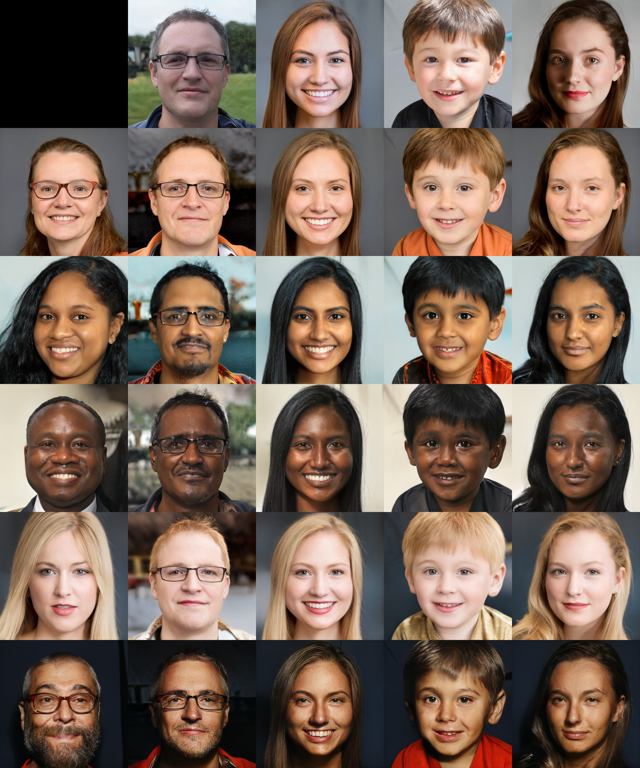

In [5]:
import PIL.Image
w,h = 128, 128
src_seeds=[55,821,1789,293]
dst_seeds=[85,100,75,458,1500]
W = w * (len(src_seeds) + 1)
H = h * (len(dst_seeds) + 1)
img = PIL.Image.open('results/style_mixing/grid.png')
img.resize((W, H))


ある潜在空間のベクトルから、潜在空間上を動かした画像が左で、別の潜在空間上のベクトルを持つ顔画像に対し、左の画像をMixingした画像が右に表示される

両方の特徴を大きくとらえた顔画像が得られているのがわかる

# 課題1

レンブラント風画像を生成する事前学習モデル(metfaces.pkl)を用いてStyle Mixingを確認しなさい

また、可能であれば、猫画像を用いて同様に確認しなさい

## ノイズ注入

Generative Adversarial Network (GAN)が、下図のように偽物を本物らしく作る生成器と、本物と偽物を見分ける識別器とが、敵対的に学習を進めることで精度の高い偽物情報を獲得することを可能とする手法であることは既に述べた

<img src="http://class.west.sd.keio.ac.jp/dataai/text/normalganfig.png" width=500>

GANもノイズが投入されており、生成器の入力である潜在変数$z$は乱数、つまりノイズである
- しかしながら生成器を通過するとランダム性が薄れ、$zZが髪の毛の流れや皮膚のしわなどが直接的に影響することが難しい
- StyleGANでは$z$を合成ネットワークにおける各ブロックに導入することで、様々な粒度で影響を与えることを可能としている

実際にノイズを与えて生成された画像をみてみよう
- ffhqを使った顔画像生成'figure04-noise-detail.png'
  - ノイズを与えて特徴を細やかに修正することができる

左が生成された顔画像であり、中央がそれに対しノイズを与えた画像である。大まかな外観は同じであるが、髪の毛のこまやかな流れなどが異なることがわかる

右は、どの部分にノイズが適用されたかという差分情報であり、差分情報が大きいほど白く映る
- このように、特に髪の毛や、皮膚のしわに影響を与えていることがわかる
- 子供の眼の場合、瞳の反射にも影響していることがわかる
- 一方で、その人の顔の向きや特徴は保持されていることがわかる

論文で紹介されている例をみてみよう
- 実際には1024x1024の画像でご覧いただかなければ、その些細な違いがつかみにくいと思うので、是非生成して確認してみることをお勧めする

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-noise.jpg" width=400>

- 上の写真について、2人の人物の写真共に、
  - 左側は全てのレイヤでノイズを適用した場合で自然な印象を受ける
  - 右側はノイズを一切いれない場合でどちらかというとノペッとしたよく言えばスベスベ肌、リアリティの観点では単調な色調となっている
- 下の写真について、2人の人物の写真共に、
  - 左側は64x64から1024x1024のファインレイヤのみノイズを入れた場合、大きなカールは表現できないが細やかな表現ができており、肌や背景のディテールも表現されている
  - 右側は4x4から32x32のファインレイヤのみノイズを入れた場合で、左の子供の髪の毛のカールの詳細や、右の男性の髪の毛の縮れ具合は再現できていない

## Truncation Trick (切り捨て技)

確率的に低い領域にある画像を間引き安定的に生成させる手法である

- 訓練画像データの分布を考慮すると、密度の低い領域、つまり類似する特徴を有する顔のバラエティが少ない場合に対する表現を十分に行うことができず、ジェネレータはこの部分の学習が困難となる場合がある
- そこで、切り捨てられた・縮小されたサンプリング空間から潜在ベクトルを作成すると、ある程度の変動は失われるが、平均画質が向上する傾向がある

例えば、変顔の人や、マイクを持っている人、髪の毛をあり得ない色に染めている、手に本を持っているなど、ほとんど同様の人がいない場合、学習が困難になる
- そこで、そのような画像を切り捨てて学習させる
- 例えば、`seeds=[91,388]`の2名について、`psis=[1, 0.7, 0.5, 0, -0.5, -1]`の$\psi$が描画されたとする

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-truncation.jpg" width=600>

- 中央の顔が平均の顔で、$psi=0$とすると全ての顔が平均顔に収束する
- $psi$の値をプラスからマイナスへ変化させると、顔の向きや視点、年齢、肌の色、髪の長さ、性別まで変化することがわかる

重み$w$について、オリジナルの潜在空間$w$から、$\bar{w}$つまりその潜在空間の平均値を引き算し、1未満の値$\psi$を掛け、さらに平均$\bar{w}$を加えることで新たな$w'$を得るとする
$$w'=(w-\bar{w})\psi+\bar{w}$$

- $\psi$の値はスタイルスケールと呼ばれる
- 潜在空間において平均からのずれ具合を補正すると、得られる画像も同様に平均へと補正される

## Truncation trick

珍しい画像や不適当な画像を切り捨てて、生成画像を安定させます

In [6]:
import os
import re
from typing import List

import dnnlib
import numpy as np
import PIL.Image
import torch

import legacy
from IPython.display import Image,display_png
#----------------------------------------------------------------------------
# Figure 8: Truncation trick.

def draw_truncation_trick_figure(seeds=[0], outdir='results'):

    png = outdir + '/truncation-trick.png'
    network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
    psis=[1, 0.7, 0.5, 0, -0.5, -1]
    w, h = 1024, 1024
    noise_mode='const'

    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    os.makedirs(outdir, exist_ok=True)
    print(png)

    latents =  np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in seeds])
    dlatents = G.mapping(torch.from_numpy(latents).to(device), None)
    dlatent_avg = G.mapping.w_avg

    canvas = PIL.Image.new('RGB', (w * len(psis), h * len(seeds)), 'white')
    for row, dlatent in enumerate(list(dlatents)):
        row_dlatents = (dlatent[np.newaxis].cpu() - dlatent_avg.cpu()) * np.reshape(psis, [-1, 1, 1]) + dlatent_avg.cpu()
        row_dlatents = row_dlatents.to(device)
        row_images = G.synthesis(row_dlatents, noise_mode=noise_mode)
        row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image.cpu().numpy(), 'RGB'), (col * w, row * h))
    canvas.save(png)
    #W = (w * len(psis)) // 4
    #H = (h * len(seeds)) // 4
    #canvas.resize((W, H))
    #return canvas
    # display_png(Image(outdir+'/truncation-trick.png'))

シード値を変更し、様々な画像で試してみるとよい

In [7]:
outdir = 'results/truncation'
seeds = [91, 388, 45 ]
draw_truncation_trick_figure(seeds, outdir)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


results/truncation/truncation-trick.png
Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


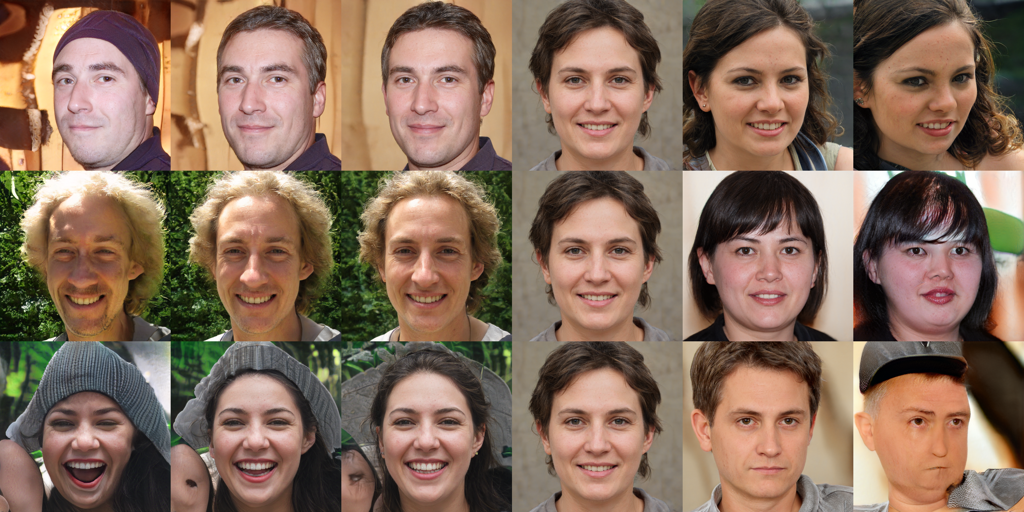

In [8]:
img = PIL.Image.open("results/truncation/truncation-trick.png")
img_resize = img.resize((img.width // 6, img.height // 6));
display(img_resize)

## Wasserstein Loss

### GANの目的関数

まずは一般的なオリジナルのGANの目的関数は次の通り

ここで、
- $p_z$ : ノイズzの分布
- $p_g$ : Generatorの生成データ分布
- $p_r$ : 現実のデータ分布
- $D(x)$ : Discriminatorが、入力されたデータxを実際のデータだと判断する確率
- $G(x)$ : Generatorが、入力されたノイズzから生成するデータ

とすると、まず、Discriminatorは現実のデータを正しく本物だと識別してほしいため、$ \mathbb{E} _ {x \sim p _ r(x)} \left[ \log D(x) \right] $を最大化すればよい

同時に、Generatorが生成したデータ$G(z)$を正しく偽物だと識別して欲しいため、$ \mathbb{E} _ {z \sim p _ z(z)} \left[ \log \left( 1 - D(G(z) \right) \right] $を最大化すればよい

次に、Generatorに関しては生成したデータをDiscriminatorが本物だと誤分類させたいので、 $$ \mathbb{E} _ {z \sim p _ z(z)} \left[ \log \left( 1 - D(G(z) \right) \right] $$ を最小化したいです。

これらを組み合わせると、以下のようなmin-max lossとなる

  $$ \min_G \max_D L(D,G) = \mathbb{E} _ {x \sim p _ r(x)} \left[ \log D(x) \right] + \mathbb{E} _ {z \sim p _ z(z)} \left[ \log \left( 1 - D(G(z) \right) \right] \\ = \mathbb{E} _ {x \sim p _ r(x)} \left[ \log D(x) \right] + \mathbb{E} _ {x \sim p _ g(x)} \left[ \log \left( 1 - D(x) \right) \right]$$

この式は、仮に現実のデータ集合にラベル+1を、Generatorが生成したデータにラベル-1を割り当てたとき、$ p _ r(x) = p (x | y = +1) $であり、$ p _ g(x) = p (x | y = -1) $となる

この$p(x | y = +1)$と＄p(x | y = -1)$は任意の2値分類器で求めることができ、これがDiscriminatorとなる

- Discriminatorの損失にBinary Cross Entropyを用いればよく、実際変形すると上記$\min_G \max_D L(D,G)$の式を得ることもできる

Discriminatorの最適解

Discriminatorの最適解を求めてみる

$L(G,D)$は期待値の部分を書き直せば

$$ L(G,D) = \int \left( p _ {r} (x) \log(D(x)) + p _ {g}(x) \log(1 - D(x)) \right) dx $$と表すことができる

$L(G,D$を最大化するような$D(x)$は、$ \hat{x}=D(x), A = p _ r(x), B = p _ {g}(x) $とすると、

$$ f(\hat{x}) = A\log \hat{x} + B \log (1- \hat{x}) $$ と表すことができる
$\hat{x}$で微分すると、

$$ \frac{d f(\hat{x})}{d\hat{x}} = \frac{A-(A+B)\hat{x}} {\hat{x} (1- \hat{x})} $$ となる

D(x)はこれを=0として、

$$ D^{\ast}(x) = \frac{A}{A+B} = \frac{ p _ r(x)} { p _ r(x)+p _ {g}(x)} $$

となる

Generatorが最適に学習すると$p_g=p_r$となり、$D^{\ast}(x)=\frac{1}{2}$となる
- つまり完璧なGeneratorができれば、Discriminatorはもはや機能しなくなることを表す
- この時のGANのlossは、
$$ L(G^{\ast}, D^{\ast}) = \int \left( p _ {r} (x) \log(D^{\ast}(x)) + p _ {g}(x) \log(1 - D^{\ast}(x)) \right) dx \\ = \log \frac{1}{2} \int p _ {r} (x) dx + \log \frac{1}{2} \int p _ {g} (x) dx = -2 \log 2 $$となる

なお、この時$p_r$と$p_g$のJS Divergence$D_{JS}(p_r||p_g)$は、$1/2(log4+L(G,D^{\ast}))$と表すことができる(計算はそれなり厄介なので省略)

最適である場合、JS Divergenceは0となるが、結果として$L(G,D^{\ast})=-2log2$を改めて導くことができる

### Wasserstein GAN (WGAN)

Wasserstein distanceはJS divergenceと同様2つの確率密度関数の距離をはかる指標で、Earth Mover's distanceとも呼ばれ、EM distanceと略されることもある
  - 実際に土を運ぶ例えで説明されている

Wasserstein distanceは、ある確率密度関数を動かしてもう一つの確率密度関数に一致させるときの最小コストを意味する

2つの確率密度関数$p_r$と$p_g$のWasserstein distanceは次のように与えられる

$$ W(p _ r, p _ g) = \inf _ {\gamma \sim \Pi(p _ r, p _ g)} \mathbb{E} _ {(x,y) \sim \gamma} \left[ ||x - y || \right] $$

$\inf$は下限でありwasserstein distanceを求めることそのものが最適化問題となる

$\gamma(x,y)$は$p_r$のある地点$x$から$p_g$のある地点$y$に動かす確率密度の単位幅に相当する面積とする
- 正確には地点$x$から全面積$\int p_r(x)dx$のうちどの面積を地点$y$へ移動するかを表す
- 移動によりp_rをp_gに一致させることから、$\sum_x\gamma(x,y)=p_g(y)$であり、逆に、$\sum_y\gamma(x,y)=p_r(x)$も成り立つ

この面積に移動距離$||x-y||$を掛けることでコストを求めることができる

候補となる動かし方戦略\gammaのうち総コストが最小となる場合を求めることでWasserstein Distanceを得ることができる

### Wasserstein GANの利点

JS DivergenceやKL DivergenceよりもWasserstein Distanceが良い理由は次の通り

- KL divergenceは2つの確率密度に重なりがない場合$\infty$に発散する
- JS divergenceは$\theta=0$で突然ジャンプし、微分不可能になる
- Wasserstein distanceは$\theta$の変化に対して滑らかな値を得ることができ、勾配降下法を利用する際に安定しやすい

### Wasserstein Distanceの実際

Wasserstein DistanceはKantorovich-Rubinstein双対性を使って、

$$ W(p _ r, p _ g) = \frac{1}{K} \sup _ {||f|| _ {L} \leq K} \mathbb{E} _ {x \sim p _ {r}} [f(x)] - \mathbb{E} _ {x \sim p _ {g}} [f(x)] $$

と変換することができる

この場合のDiscriminatorは良い$f$を求めることを目的とするが、そのためにWGANは損失として$p_r$(現実のデータの分布)と$p_g$(Generatorが生むデータの分布)間のWasserstein distanceを利用する
- つまり、学習が進むにつれてGeneratorは現実のデータの分布に近いデータの分布を出力できるようになる

$$ L(p _ {r}, p _ {g}) = W(p _ {r}, p _ {g}) = \max _ {w \in W} \mathbb{E} _ {x \sim p _ {r}} [f(x)] - \mathbb{E} _ {z \sim p _ {z}} [f(g _ {\theta}(z))] $$

ただ、もう一つ勘案しなければならないことがある

### Lipschitz 連続性

Wasserstein distanceの$f$には$||f||_L \le K$という制約がある
- この制約をK-リプシッツ連続という

関数$f:ℝ → ℝ$は次の条件を満たす時にK-リプシッツ連続となる

「ある定数$K≥0$が存在し、全ての$x1,x2∈R$に対して$ |f(x _ {1} - f(x _ {2})| \leq K |x _ {1} - x _ {2}| $となる
- つまり任意の区間の傾きがある値K(リプシッツ定数)より小さいことを意味する

任意の場所で微分可能な関数はリプシッツ連続であるが、逆は成り立たない(例えば、f(x)=|x|は原点で微分不可能)

$ L(p _ {r}, p _ {g}) $の式における$f$はK-リプシッツ性を維持しなければならないが、その簡単かつ強力な方法は、重み$w$を更新した後、$w$を$[-0.01, 0.01]$といった小さな範囲でクリップする方法である
- パラメータ空間$W$は小さくなり、$f$の傾きを抑えることができる
- 一方でネットワークが極端に単純化され学習が収束しない場合が想定される

そこで、勾配制約という手法が提案された

$$\lambda 𝔼_{\hat{x}～ℙ_\hat{x}}[(||\nabla_{\hat{x}}D(\hat{x})||_2-1)^2]  $$

$\nabla$は勾配演算子、$\lambda$はPnelty coefficientで10といったの値

そこで、もともとのcricic Lossに、勾配制約を加えて全体のロストする

### Wasserstein GANの学習

Wasserstein lossを、Generatorのパラメータ$\theta$で微分すると

$$ \frac{\partial}{\partial \theta} L(p _ {r}, p _ {g}) = \frac{\partial}{\partial \theta} - \mathbb{E} _ {z \sim p _ {z}} [f _ {w}(g _ {\theta}(z))] $$

となり、サンプル近似によって

$$ \frac{\partial}{\partial \theta} - \mathbb{E} _ {z \sim p _ {z}} [f _ {w}(g _ {\theta}(z))] = \frac{1}{M} \sum_{m=1}^{M} \frac{\partial}{\partial \theta} - f _ {w}(g _ {\theta}(z_m)) $$

と近似できる(Mはバッチサイズ)

よって、WGAN全体の学習は次の手順を繰り返すことになる
- Discriminatorのパラメータ$w$に関して、WGANのLossを微分し、Wasserstein distanceの良い近似を求めるように$w$を更新する
- Discriminatorのパラメータ$w$のリプシッツ連続性を保つため、クリッピングを行う
- Generatorのパラメータ$\theta$に関して、Lossを微分し、Wasserstein distanceを小さくするように$\theta$を更新する

### StyleGANは、正確にはGANではない？

これまでの議論を平易に纏める

- StyleGANは真贋の区別はしていない
- 0から1という確率表現である必要がない
  - 従来Discriminatorの出力にはSigmoidが使われており、勾配消失問題があった
      - 高精細画像を扱うGANでは、本物と偽物で大きく違うことが想定される
      - Sigmoidを利用する場合原点から離れたところでは勾配がほぼ0となる
      - すると少々偽物が変化したところで評価値が変わらない、つまり変化を伴うようにパラメタが動いてくれない
      - 結果的に学習をうまく進めることができない
      - JSダイバージェンスも同様の問題が存在する
  - Wasserstein Distanceを利用し、結果的に誤差をいくらでも大きくできるため勾配消失が発生しにくい
- 従って誤差の計算に対数を利用しない
- DiscriminatorからCritic(批評家)へ名称が変更されている
  - Criticは本物画像の出力と偽画像の出力の差を最大化する
    - Discriminatorは真贋判定を(0か1かの判定)行わないため、Criticと呼ぶ
    - 通常のGANの損失計算では、本物・偽物それぞれでBinary Cross Entropyを計算する  
    本物画像判定: $log(p_r)$つまり、本物画像である確率の対数で、$tlogD(x)$
    偽物画像判定: $log(1-p_r)$とし、$(1-t)log(1-D(G(z)))$  
    Minimax Lossとして計算し生成器は損失関数を最小化、識別器は最大化する  
    $Loss = tlogD(x)+(1-t)log(1-D(G(z)))$
    - Wasserstein Lossは本物画像と偽物画像の差を基に計算する  
    $Loss = D(x)-D(G(z))$であり、CriticはLossを最大化し、Generatorは$D(G(z))$の項を最大化する


### その他のStyleGAN

データセットを変えれば、特に顔に限らず、様々な画像を得ることができる

- bedroomsを使った寝室生成'figure10-uncurated-bedrooms.png'
- carsを使った自動車生成'figure11-uncurated-cars.png'

車はなかなか苦労している
- 人間の顔よりも表現空間が広いのか？


是非、StyleGANのコードもPythonで記載されており見やすいため見てみるとよい
- nVidiaが提供している関数を使うという程度でも、様々なことができる

なお、StyleGANで本格的に遊ぶには、ある写真に写った顔の潜在空間表現が必要となる
- これは少々やっかいで、様々な方法が提案されている
- やはり機械学習を用いて潜在空間表現を手に入れるという手法がある

# StyleGAN2

## StyleGANの問題点

詳細は以下の論文を参照すること
https://arxiv.org/abs/1912.04958

StyleGANはいくつか問題がある
- 機械学習によるミス、例えば顔にしみが出たりする
  - このしみをdropletと呼び、ちょうど印刷するときに油や水が落ちたような画像となる
  - 64x64以上の画像でこのような画像が発生することが知られている
  - Adaptive Instance Normalizationを利用していることが根本問題である
- 斜めを向いた顔画像で歯の並びが不自然になる
  - 歯の位置が顔の向きと一致していない、つまり、局所的な特徴が大局的な特徴に追従しない、という問題(artifacts)がある
  - mixing regularizationによる問題

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-tooth.jpg" width=600>

## StyleGAN2のネットワークと問題の改善

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-net.png" width=500>

- 上がジェネレータ、下がディスクリミネータのネットワークである
- 緑のネットワークがStyleGAN2で改良され採用されたネットワークである
- 灰色は提案されたが採用されなかったネットワークである

見てみると、
- ジェネレータに関して、緑のネットワークが表しているように、PG-GANは採用されなくなった
- ディスクリミネータに関して、出力に入力情報をそのまま足し合わせるという構造を有しており、ResNetの残差ブロックと同様の構造となっている

スタイルブロックも改良された
- 左から順に、StyleGANのネットワーク、次にその詳細な構造、次にStyleGAN2のネットワーク、最後がその実装である

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-style.png" width=700>

- StyleGANでは、潜在空間からの情報$A$を正規化であるAdaINに適用させ、ノイズ情報を正規化の前に足しこんでいた
- そのプログラム実装では次のように対応している

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-imp.png" width=350>

  - Norm mean/stdブロックは、Instance Normalizationを行っている

さて、StyleGan2では、次のように変換している
- $B$のノイズの入力がブロックの外に出されている、つまり、正規化の後になっている
- モジュレーションは標準偏差のみ利用しており、AdaINは採用されておらず標準偏差のみを利用している

実装の通り、$A$は$w$と共にモジュレーションを行い、出モジュレーションされて畳み込み層の特徴マップとして利用している
- 式は掲載しないが、各特徴量(潜在空間)であるスタイルベクトルの値に$w$という畳み込みの重みを掛けてスケーリングした$w'$を求め、この$w'$を分散で割ることでデモジュレーションを行う

StyleGAN2には、メモリ消費が大きいという問題が残されている
  - ここは解決する気がないらしい(売りたいから？)
  - 1024x1024で16G以上のメモリが必要(普通のGPUではアウトでも、AI用途なら20G超えも普通なので趣味でなければ困るわけではないが…、ホビーでも2080Tiやら、3090とか)
  - 128x128でも11G以上必要(Google Colabでもガチャに失敗すると無理な場合がある)

StyleGAN3がすでに提供されており、動画への対応と、PyTorchへの記述様式の変更が行われている

### StyleGAN2の実行例

- 潜在空間で連続性を持たせることで画像品質向上している
- StyleGANに比べてFID等が大きく向上する。

Progressive Growingをやめる代わりに、GeneratorとDiscriminatorの表現力を上げることで高解像度生成ができるようにしている
- もともと、個々のGeneratorが独立しているため頻出する特徴を生成する傾向にあり、その結果顔が動いても歯が追随していかないという結果が生まれていた

下図はすべてStyleGAN2で生成された画像である。なお、それぞれは異なる画像データより作成された異なるモデルであることに注意する。

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stylegan2-t.png" width=600>

<img src="http://class.west.sd.keio.ac.jp/dataai/text/StyleGAN2-1.png" width=600>

<img src="http://class.west.sd.keio.ac.jp/dataai/text/StyleGAN2-2.png" width=600>

<img src="http://class.west.sd.keio.ac.jp/dataai/text/StyleGAN2-3.png" width=600>



# モーフィング画像の作成

顔画像を2つ用意し、1つ目の顔画像から2つ目の顔画像に自然に変化するような顔画像や動画を作成する

## 関連ツールの準備

## pluseによる顔画像の事前処理

顔画像では解像度や、顔の位置や大きさが揃っていないため、これを整えるツールを導入する

PULSE: Self-Supervised Photo Upsampling via Latent Space Exploration of Generative Models

「生成モデルの潜在空間探索による自己教師付き写真アップサンプリング
」

アップサンプルもStyleGANを利用する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/transformation.gif" width=400>

StyleGANの潜在空間を利用し、「存在しない顔画像」を生成するため、版権上の問題も解決する

- データセットはfacebookなどのオプトインを取得した顔画像で構成されている
- ただし、これについては近年版権の扱いについて様々な議論がある



In [9]:
!git clone https://github.com/adamian98/pulse.git

Cloning into 'pulse'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102 (from 1)
Receiving objects: 100% (102/102), 164.43 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [10]:
#!pip install moviepy

# ninja
#!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip > /dev/null
#!sudo unzip ninja-linux.zip -d /usr/local/bin/ > /dev/null
#!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force > /dev/null

作業ディレクトリに移動

In [11]:
%cd /content/stylegan2-ada-pytorch


/content/stylegan2-ada-pytorch


関連ライブラリを導入する

In [12]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt
import torch
import dnnlib
import legacy
import imageio
from tqdm.notebook import tqdm

from moviepy.video.fx.resize import resize
from moviepy.editor import VideoFileClip

# テスト画像のセットアップ

適当なところから画像をとってくる

- jpgファイルであることが必要である
- 証明写真のような画像がよい
- メガネの処理がいまいちなので、メガネをかけていない方が良い
- それなりに解像度があれば、PLUSEで高解像度化される
- URLを変えれば画像を変更でき、また、直接画像をフォルダに加えてもよい

In [13]:
!rm -rf inputs
!mkdir -p inputs/img inputs/align
!wget -c https://hips.hearstapps.com/amapn-prod-jp.s3.amazonaws.com/elljp/elle-mig/images/culture/feature/daniel_radcliffe16_1129/3/1754607-1-jpn-JP/2002-10-25.jpg \
      -O ./inputs/img/src.jpg

!wget -c https://www.tvgroove.com/wp-content/uploads/2020/03/Daniel-Radcliffe.jpg \
      -O ./inputs/img/dst.jpg

--2024-08-27 04:39:18--  https://hips.hearstapps.com/amapn-prod-jp.s3.amazonaws.com/elljp/elle-mig/images/culture/feature/daniel_radcliffe16_1129/3/1754607-1-jpn-JP/2002-10-25.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215212 (210K) [image/jpeg]
Saving to: ‘./inputs/img/src.jpg’

./inputs/img/src.jp 100%[===================>] 210.17K  --.-KB/s    in 0.01s   

2024-08-27 04:39:18 (16.0 MB/s) - ‘./inputs/img/src.jpg’ saved [215212/215212]

--2024-08-27 04:39:18--  https://www.tvgroove.com/wp-content/uploads/2020/03/Daniel-Radcliffe.jpg
Resolving www.tvgroove.com (www.tvgroove.com)... 118.27.29.12
Connecting to www.tvgroove.com (www.tvgroove.com)|118.27.29.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127713 (125K) [image/jpeg]
Saving to: ‘./inputs/i

## 顔画像のアライメント

顔が中心にくるようにアライメントを行う

- PULSEに含まれるalign_face.pyを利用する

In [14]:
%cd pulse
!python align_face.py \
  -input_dir /content/stylegan2-ada-pytorch/inputs/img \
  -output_dir /content/stylegan2-ada-pytorch/inputs/align \
  -output_size 1024 \
  -seed 12

/content/stylegan2-ada-pytorch/pulse
src.jpg: Number of faces detected: 1
dst.jpg: Number of faces detected: 1


顔画像を確認する

/content/stylegan2-ada-pytorch


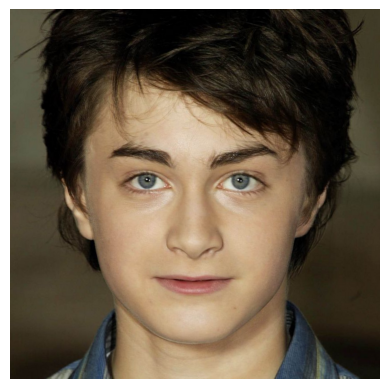

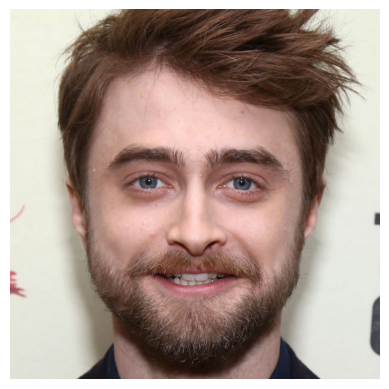

In [15]:
%cd /content/stylegan2-ada-pytorch

align_src = cv2.imread('/content/stylegan2-ada-pytorch/inputs/align/src_0.png')
img = cv2.cvtColor(align_src, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

align_dst = cv2.imread('/content/stylegan2-ada-pytorch/inputs/align/dst_0.png')
img = cv2.cvtColor(align_dst, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# モーフィングの作成

In [16]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# Invert to GAN

顔画像から潜在空間ベクトル(潜在空間における表現)を獲得する手法を一般にinvert処理と呼ぶ
- なお、潜在空間表現は、$z$ではなく$w$を選択することで、特長表現の基底ベクトルを残すことができるといわれている
- zの次元が512次元であるのに対してwは18x512次元でありwの方が自由度が高く表現力が高い

ここでは、project.pyを利用する

潜在変数の初期値を与えて、Generatorに入力し、元の画像と一致するように潜在変数をSGDで最適化する方法が良く用いられる

基本的な方針は次の通り、
- wをランダムに選択
- wを勾配法の対象とする
- Gを準備するが、Gは固定とする
- Gを利用して画像を生成
- その生成画像と目的画像の差をロスとして誤差逆伝搬
  - この時Gは固定されているため、wのみ調整される
- これを繰り返してwを同定する

実際のprojector.pyでは、
- Gをdeepcopyしつつ、evalモードとし、勾配を固定してGPUに転送する  
`G = copy.deepcopy(G).eval().requires_grad_(False).to(device)`
- zをランダムに生成してwを生成
 - この時10,000個のzについてのwを取得し、wの平均と分散を求めてその周辺の乱数を出すように調整している
 - このあたりのパラメタを調整することで、ぶっ飛んだ顔画像を生成しやすくなるかもしれない
- zを同定するが、そのロスとして単純な画像差分の場合、顔の向きなどの違いから「画素データ」に着目しすぎた結果、意図しない最適化が行なわれる可能性がある
  - そこで、vgg16の特徴量を元にロスを求めて最適化するという手段をとる
- w最適化の後、wを固定し、Noiseを同じようにMSE Lossを使って最適化(,画像が平滑化されるため、何度も最適化を繰り返すのは良くなく、各一回だけの最適化をすべきとされている)

以下では200ステップで求めているが、1,000ステップ程度かけた方が良い場合がある
- 時間に余裕があれば、1,000などといった大きな値にするとよい

In [17]:
!python projector.py \
  --save-video 0 \
  --num-steps 200 \
  --outdir=outputs/src \
  --target=inputs/align/src_0.png \
  --network={NETWORK}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

In [18]:
!python projector.py \
  --save-video 0 \
  --num-steps 200 \
  --outdir=outputs/dst \
  --target=inputs/align/dst_0.png \
  --network={NETWORK}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

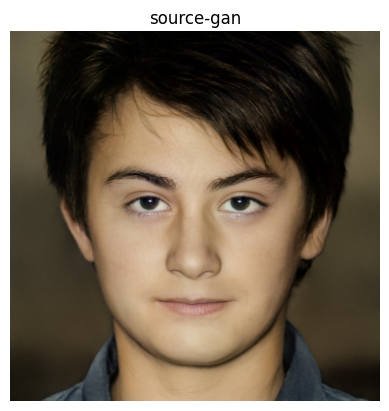

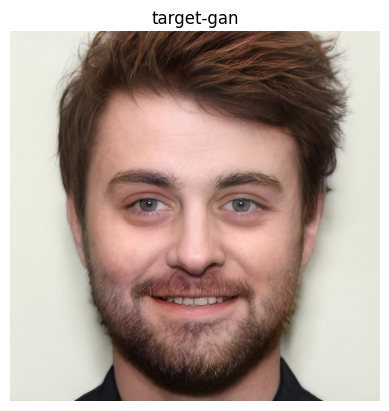

In [19]:
img_gan_source = cv2.imread('./outputs/src/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.axis("off")
plt.show()

img_gan_target = cv2.imread('./outputs/dst/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.axis("off")
plt.show()

# Morphing

2つの潜在空間ベクトルの間を等間隔で刻んでモーフィング画像を生成する

In [20]:
STEPS = 10
FPS = 20
FREEZE_STEPS = 20
image_array = []

In [21]:
lvec1 = np.load('./outputs/src/projected_w.npz')['w']
lvec2 = np.load('./outputs/dst/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

#video = imageio.get_writer('./movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

#  for i in range(repeat):
#    video.append_data(synth_image)
  plt.imshow(synth_image)
  plt.axis("off")
  plt.show()
  image_array.append(synth_image)
  current = current + step


#video.close()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
synth_image.shape

(1024, 1024, 3)

In [23]:
import cv2
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 5, (synth_image.shape[0], synth_image.shape[1]))
for i in range(0, len(image_array)):
  img = image_array[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
vid.release()

上手く動作したであろうか

## Image Crossover

顔画像の一部をマスクした画像をターゲットイメージとして利用することで、潜在変数の部分的な最適化が可能となる


<img src="http://class.west.sd.keio.ac.jp/dataai/text/imgcrossover.jpg" width=600>


- さらにマスクをかけた場所を別の顔画像を使って最適化させれば、2つの顔画像を自然な形で合成できる


<img src="http://class.west.sd.keio.ac.jp/dataai/text/imgcrossover2.png" width=350>

## Image Inpainting

Image Crossoverの発展でマスクの場所を自由に変えることで髪型など特定の場所のみ変更することで、Image Inpaintingを実現できる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/imginpainting.jpg" width=600>




## Local style transfer

Style Transferのようにある部分だけスタイルを入れ替えるLocal style transferも同様に構築できる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stylelocalxfer.jpg" width=600>


# 潜在変数の意味的境界

モーフィングのように潜在変数を動かすと、生成される画像の性別や年齢、ポーズなどが連続的に変化する
- では潜在変数をどの方向に動かしたらなにが自由に操作できるのか？

潜在変数が動く空間、潜在空間のイメージは次の図の通り

<img src="http://class.west.sd.keio.ac.jp/dataai/text/superplane1.png" width=300>

潜在変数を動かすことで性別が連続的に変わっていくのであれば、性別が男性から女性に変わる境界面が存在するはずである
- すなわち「性別の分離超平面」により男性と女性が判別できる画像が生成され、境界面のすぐ近くではどちらとも言えない中性的な画像、遠くで歯性別がより濃く表現された画像が生成されると考えられる

ではその分離境界面を見つけることができるのか？
- もし見つけることができれば、その法線ベクトルnを定義し、潜在変数をnと平行に動かしてあげれば性別を自由に操作できるはずである


同様のことを性別以外にも、smile,age,eyeglasses,poseについてできるはずである
- この場合、性別中性の超平面ではなく、例えば年齢20歳の超平面といった形になる

注目するべきは、「そのような超平面の法線ベクトルが、単一ベクトルで表現できるのか？」ということである

例えば、次のような形態をしていれば、そのようなベクトルを抽出できない

<img src="http://class.west.sd.keio.ac.jp/dataai/text/superplane2.png" width=600>

これについては、Perceptual Path Lengthに関するStyleGANのある特長が関係している



### Perceptual Path Length (知覚的経路長)
- 潜在空間にもつれがあると、そこを通過する際にスムーズではない画像が生成される
  - これを、Perceptual Path Lengthという指標で評価する
- ある潜在空間ベクトルAからBへ移動するように生成させるとき、生成画像から抽出した特徴の空間は、情報が限定的であるため曲がってしまう
  - うまく距離が測れれば、曲がっていないほど距離が短くなるといえる
  - この時、生成画像もよりスムーズな変化となる

特徴量のDisentanglementにも関係する

- 特徴量分解といわれる
- 潜在空間のある方向が画像の1つの特徴に対応しているとする

例えば、下図において
- 左が、学習させた顔画像が持っている潜在空間
  - 例えば、左右が男女で、上下が髪の長さとすると、髪の長い男性のデータがない、といった状況を意味している
- 中央が、これまで一般的であった$z$から生成した潜在空間
  - 無理やり$z$の表現空間にマッピングしてしまうため、空間が曲がってしまう
    - PG-GANも同様、潜在空間をうまく制御できない
  - データがない領域が消えてしまう
  - この空間上では、特徴量の線形的演算ができない
  - この曲がった空間でパスを移動すると、画像の遷移が不自然になる
- 右がStyleGANの方法
  - 学習に利用する顔画像が持つ「理想的な」潜在空間は手に入らないが、その形や距離を保存したままマッピングすることはできそうだ(できてしまった)
  - この上ならば、線形演算できる
  - これがマッピングネットワークの役割
    - もつれた空間を「ほどく」ことができる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/disentangled.png" width=400>

Perceptual Path Lengthは、潜在空間の滑らかさ評価するための指標であり、$w$について次のように定義されている

$$l_w = \mathbb{E}[\frac{1}{\epsilon^2}d(g(lerp(f(\mathbf{z_1}),f(\mathbf{z_2}); t)), g(lerp(f(\mathbf{z_1}),f(\mathbf{z_2}); t+\epsilon)))]
$$

ここで、$leap$は2点をパラメータ$t$で線形補間する操作であり、$g$はSynthesis Networkを表す関数、$d$はPerceptual Distance、$\epsilon$は微小ノイズであり、$10^{-4}$といった小さな値が使われる

$t$の選び方によって、Path lengthにはfullとendの2種類が定義されており、
- fullでは、$t ～ U(0,1)$と選び、
- endでは、$t \in 0, 1$と選ぶ

結果として、fullでは、$f(\mathbf{z_1})$と$f(\mathbf{z_2}$の線形補間およびその周辺でのPerceptual Distanceを評価し、endでは、$f(\mathbf{z_1})$と$f(\mathbf{z_2}$
のいずれかの周辺でのPerceptual Distanceを評価することになる

一般的には、endの方が訓練中に入力として経験した点の周辺での評価になるため、Perceptual Path Lengthは小さくなる
- 逆に、fullは、訓練中に経験していない点の周辺での評価になる可能性があるため、Perceltual Path Lengthは小さいことが望ましいが、endよりは大きくなることが予想される

なお、別途$z$についての定義も行われている

$$l_z = \mathbb{E}[\frac{1}{\epsilon^2}d(G(slerp(\mathbf{z_1},\mathbf{z_2}; t), G(slerp(\mathbf{z_1},\mathbf{z_2}; t+\epsilon)))]
$$
ここで、GはGeneratorである

このあたりが、StyleGANにおける潜在空間表現の本質になるが、その理解はかなり難解であろう

纏めると次のようになる
- 中間潜在空間$w$が固定分布に従ったサンプリングをサポートする必要がないように$z$から多層のFC層を利用して生成しており、これは教師なし学習される
- $w$のサンプリング密度は学習された、多層のFC層により構成される、区分的連続マッピング(piecewise continuous mapping)$f(z)$によって誘導される
  - ある画像に対してある$z$が対応するが、似たような塊であるpieceが連続して並んでいるようなマッピングが行なわれている(できてしまっているのだから仕方がない)
- このマッピングは$w$を "unwarp" つまり絡まらないように解いた形にしており、変動要因としての特徴量がより線形になるように適応させることができる
  - その理由は、エンタングル表現、すなわちそれぞれの特徴が絡んだ状態であるよりも、非エンタングル表現、すなわち解いた状態で表現した方が連続して並べやすい、また、現実的な画像を生成しやすいはずであるためである
- 教師なし設定、すなわち、変動要因が事前に知られていない場合、訓練により、よりエンタングルされていない$w$が得られると期待できる

ということになる

## 分離境界面の決定

分離境界面の決定にはSVMを用いる

StyleGANで生成した画像に対し各属性でラベル付けして、潜在変数をよく分離できるような超平面を推定する
- Distanceは法線ベクトルと潜在変数の内積であり、距離と方向を含む

SVMで得られた超平面で画像を評価すると次の図のようになり、距離0付近(超平面付近)ではどちらの属性とも言えない画像が、遠くでは属性が色濃く反映された画像が分布している

<img src="http://class.west.sd.keio.ac.jp/dataai/text/latentmeaning2.jpg" width=450>


## Conditional manipulation
超平面を求めることができれば、法線方向に潜在変数を動かすことで属性操作が可能となるが、実際には各属性の法線ベクトルが直交しているとは限らないため、ある属性を動かすと別の属性も動くということが起こる

これを防ぐため、変更したい属性法線n1から変更したくない属性法線n2のn1成分を減算し、ようするに平面2に関して平行になるよう動かすようにすればよい

結果的に次のような画像群を得ることができる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/latentmeaning3.jpg" width=600>


### $w$の意味と属性変更kの別の方法に関する検討

潜在変数$w$は512次元のベクトルが18個で構成されるが、これら18個のベクトルは生成段階の異なる解像度を構築する層の入力として利用されている
- 4x4のときのlayerで最初の2個、8x8で次の2個、そして最後の1024x1024で2個

従って、各解像度における潜在変数の役割が異なるといえる
- 解像度が低い層に入力される潜在変数は顔の向きや形といった大域的な情報を操作している
- 解像度が高い層では目や口元といった局所的な情報を操作している

これに着目し、表情を操作する層を見つけ、その層の潜在変数だけをcontent lossで最適化し、それ以外の潜在変数に関してはstyle lossで最適化すれば、より明確にappearanceとexpressionを分けることができる
- 最終的な潜在変数は別々に最適化した潜在変数を用いて次のように表現できる

$$s_0 = \alpha s_q + (1-\alpha) s_2$$

この方法でも、可能ではあるが、クオリティにおいて劣る傾向にある

# 潜在空間操作

実際に年齢(age)、メガネをかけているかどうか(eyeglasses)、性別(gender)、顔の方向(pose)、表情(smile)を操作する

表情がsmileであるのは、インターネット上から獲得した画像データでは、笑顔と無表情のどちらかのデータが多く、怒っていたり、泣いていたりするデータが少ないため学習できないという事情があるためである

また、先に示したような都合のよい垂線が求まるかどうかも実際には一筋縄で解決できる問題ではないため、様々な実装や試行がなされている

ここでは、



# Fetch Codebase and Models

In [24]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489 (from 1)
Receiving objects: 100% (613/613), 13.72 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (204/204), done.


# Define Utility Functions

In [25]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [26]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_celebahq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

generator = build_generator(model_name)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

  state_dict = torch.load(self.model_path)



# Sample latent codes

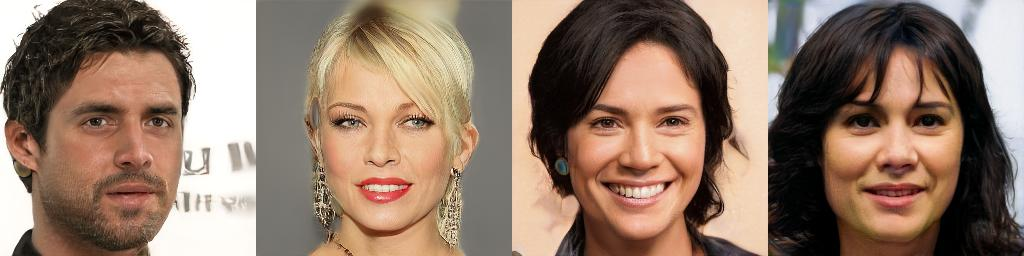

In [27]:
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

# Edit facial attributes

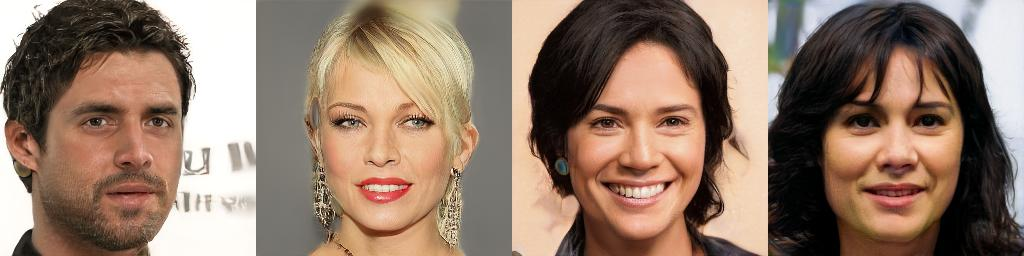

In [28]:
#@title { display-mode: "form", run: "auto" }

age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = 0 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)

# 課題2

自分の写真と別の写真(推しの写真)の2枚からモーフィング画像を作成しなさい



# 課題3

- 写真を準備し、その写真を加工して肌の色を変える、髪の毛の色を変える、髪の毛の長さを変えるなどして、オリジナルの写真と加工した写真の2つの画像の潜在空間を獲得しなさい

- その潜在空間の間をとることで、モーフィングを作成しなさい

- 2つの潜在空間の差から「差分となるベクトル」を抽出しなさい

- 別の写真に「差分となるベクトル」を加えたときどのような顔画像が生成されるか確認しなさい
